# Linear Tree Regression

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from pprint import pprint
from sklearn.linear_model import LinearRegression

%matplotlib inline
sns.set_style("darkgrid")

## Train-Val-Test-Split

In [2]:
def train_val_test_split(df, val_size, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))
    if isinstance(val_size, float):
        val_size = round(val_size * len(df))

    a = val_size+test_size
    b = test_size
    train_df = df.iloc[:-a]
    val_df = df.iloc[-a:-b]
    test_df = df.iloc[-b:] 

    return train_df, val_df, test_df

## Helper Functions

### Potential Splits

In [3]:
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):          # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

### Split Data

In [4]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

### Determine Best Split

In [5]:
def calculate_mse(data):
    actual_values = data[:, -1]
    if len(actual_values) == 0:   # empty data
        mse = 0
        
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    
    return mse

In [6]:
def calculate_overall_metric(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric =  (p_data_below * calculate_mse(data_below) 
                     + p_data_above * calculate_mse(data_above))
    
    return overall_metric

In [7]:
def determine_best_split(data, potential_splits):
    
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            
            current_overall_metric = calculate_overall_metric(data_below, data_above)

            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

### Create Leaf (Regression)

In [8]:
def create_leaf(data):
    
    X = data[:, :-1]
    y = data[:, -1]
    reg = LinearRegression().fit(X, y)
    m = reg.coef_
    b = reg.intercept_
    
    return m, b

## Decision Tree Algorithm

In [9]:
sub_tree = {"question": ["yes_answer", 
                         "no_answer"]}

In [10]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [11]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (len(data) < min_samples) or (counter == max_depth):
        m, b = create_leaf(data)
        return m, b

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            m, b = create_leaf(data)
            return m, b
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        #if yes_answer == no_answer:sub_tree = yes_answer else:
        sub_tree[question].append(yes_answer)
        sub_tree[question].append(no_answer)
        
        return sub_tree

In [12]:
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [13]:
def calculate_r_squared(df, tree):  
    
    predictions = np.array([])
    for i in range(len(df.label)):
        example = df.iloc[i]
        m, b = predict_example(example, tree)
        predictions = np.append(predictions, np.dot(m, example[:-1])+b)

    data = df.values[:]
    mean = data[:, :-1].mean()
    ss_res = sum((data[:, -1]- predictions)**2)
    ss_tot = sum((data[:, -1] - mean) ** 2)
    r_squared = 1 - ss_res / ss_tot #r_squared 
    
    return r_squared

## Visualizing

In [14]:
def create_plot(df, tree):    
    
    data = train_df.values[:, :]
    
    actual = df.label
    predictions = df.label
    for i in range(len(df.label)):
        example = xample = df.iloc[i]
        m, b = predict_example(example, tree)
        predictions = predictions.replace(predictions.iloc[i], np.dot(m, example[:-1])+b)
        
    plot_df = pd.DataFrame({"actual": actual, "predictions": predictions})
    
    plot_df.plot(figsize=(18, 5))
    
    return

## Format of the data

1. Last column of the data frame must contain the label and it must also be called "label"
2. There should be no missing values in the data frame 

# Bike Sharing Dataset

## Load and Prepare Data

In [15]:
df = pd.read_csv("day.csv", parse_dates=["dteday"])
df = df.drop(["instant", "casual", "registered"], axis=1)
df = df.rename({"dteday": "date"}, axis=1)

In [16]:
df.size

9503

In [17]:
date_column = df.date

df["day_of_year"] = date_column.dt.dayofyear
df["day_of_month"] = date_column.dt.day

df["quarter"] = date_column.dt.quarter
df["week"] = date_column.dt.week

df["is_month_end"] = date_column.dt.is_month_end
df["is_month_start"] = date_column.dt.is_month_start
df["is_quarter_end"] = date_column.dt.is_quarter_end
df["is_quarter_start"] = date_column.dt.is_quarter_start
df["is_year_end"] = date_column.dt.is_year_end
df["is_year_start"] = date_column.dt.is_year_start

df = df.set_index("date")

<ipython-input-17-7f76abfc0f02>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week"] = date_column.dt.week


In [18]:
df["label"] = df.cnt
df = df.drop("cnt", axis=1)

In [19]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,day_of_month,quarter,week,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,label
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,...,1,1,52,False,True,False,True,False,True,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,...,2,1,52,False,False,False,False,False,False,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,...,3,1,1,False,False,False,False,False,False,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,...,4,1,1,False,False,False,False,False,False,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,...,5,1,1,False,False,False,False,False,False,1600


## Train-Val-Test Split 

In [20]:
random.seed(0)
train_df, val_df, test_df = train_val_test_split(df, 0.15, 0.15)

## Grid Search

In [21]:
grid_search = {"max_depth": [], "min_samples": [], "r_squared_train": [], "r_squared_val": [], "r_squared_test": []}
for max_depth in range(1, 7): 
    for min_samples in range(5, 30, 5):
        tree = decision_tree_algorithm(train_df, max_depth=max_depth, min_samples=min_samples)
        
        r_squared_train = calculate_r_squared(train_df, tree)
        r_squared_val = calculate_r_squared(val_df, tree)
        r_squared_test = calculate_r_squared(test_df, tree)
        
        grid_search["max_depth"].append(max_depth)
        grid_search["min_samples"].append(min_samples)
        grid_search["r_squared_train"].append(r_squared_train)
        grid_search["r_squared_val"].append(r_squared_val)
        grid_search["r_squared_test"].append(r_squared_test)
        
    print(f"Progress: Iteration {max_depth}/6")
        
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("r_squared_val", ascending=False).head()
grid_search.sort_values("r_squared_test", ascending=False).head()

Progress: Iteration 1/6
Progress: Iteration 2/6
Progress: Iteration 3/6
Progress: Iteration 4/6
Progress: Iteration 5/6
Progress: Iteration 6/6


,max_depth,min_samples,r_squared_train,r_squared_val,r_squared_test
0,1,5,0.97928,0.983062,0.963032
2,1,15,0.97928,0.983062,0.963032
3,1,20,0.97928,0.983062,0.963032
4,1,25,0.97928,0.983062,0.963032
1,1,10,0.97928,0.983062,0.963032


## Plotting a Tree

In [22]:
best_max_depth = 1
best_min_samples = 5

tree = decision_tree_algorithm(train_df, max_depth=best_max_depth, min_samples=best_min_samples)
pprint(tree)

{'temp <= 0.430833': [(array([ 3.96724403e+02,  1.64809965e+03, -4.17925430e+02, -5.36144427e+02,
        4.22814236e+01,  2.98365678e+02, -5.50175476e+02,  1.59834303e+04,
       -9.90443887e+03, -1.26650045e+03, -4.00592645e+03,  1.58713723e+01,
       -1.97205345e+01, -3.39517222e+01, -1.32964553e+01, -1.62754107e+01,
        3.50701391e+01,  1.60860512e+03,  5.24289874e+02, -1.55392367e+03,
       -9.03766671e+02]),
                       2217.273113511288),
                      (array([  213.29688041,  2361.75851734, 12884.19233773,  -150.27150523,
          41.60610425,  -275.89318202,  -527.14153152,  6505.90947537,
       -6579.41710863, -1592.35905473, -3263.51220794,  -420.5325595 ,
         410.70183875,  -473.45074092,    22.76889445,   -40.04276549,
        -538.45180895,   617.65006616,   287.80765334,     0.        ,
           0.        ]),
                       -7110.84273979975)]}


## Estimating Accuracy using $R^2$

In [23]:
calculate_r_squared(test_df, tree)

0.9630316539657128

## Visualizing Actual and Predicted Data

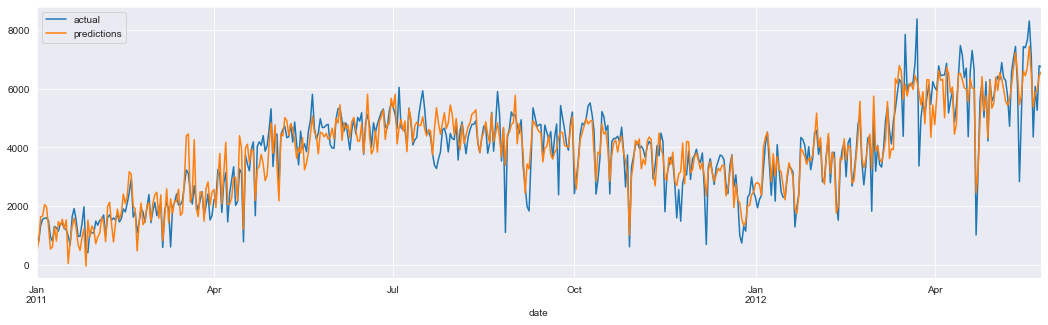

In [24]:
create_plot(train_df, tree)

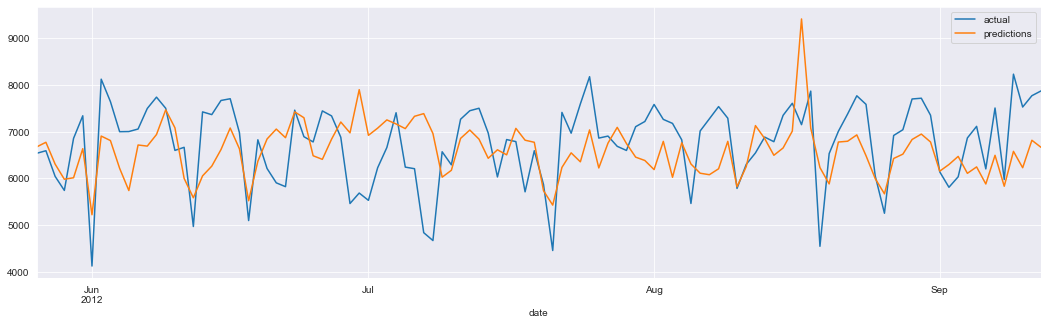

In [25]:
create_plot(val_df, tree)

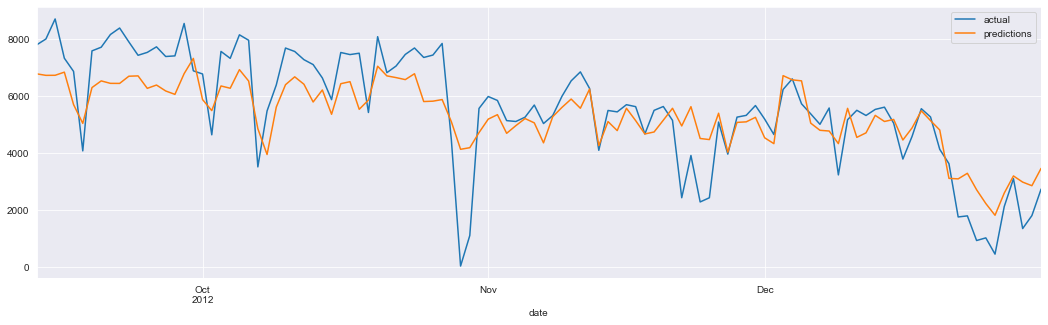

In [26]:
create_plot(test_df, tree)

# AirfoilSelfNoise Dataset

## Load and Prepare Data

In [27]:
df = pd.read_csv("AirfoilSelfNoise.csv")
df.size

9018

In [28]:
df["label"] = df.SSPL
df = df.drop("SSPL", axis=1)

In [29]:
df.head()

,f,alpha,c,U_infinity,delta,label
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


## Train-Val-Test-Split

In [30]:
train_df, val_df, test_df = train_val_test_split(df, 0.15, 0.15)

## Grid Search

In [31]:
grid_search = {"max_depth": [], "min_samples": [], "r_squared_train": [], "r_squared_val": [], "r_squared_test": []}
for max_depth in range(1, 7): 
    for min_samples in range(5, 30, 5):
        tree = decision_tree_algorithm(train_df, max_depth=max_depth, min_samples=min_samples)
        
        r_squared_train = calculate_r_squared(train_df, tree)
        r_squared_val = calculate_r_squared(val_df, tree)
        r_squared_test = calculate_r_squared(test_df, tree)
        
        grid_search["max_depth"].append(max_depth)
        grid_search["min_samples"].append(min_samples)
        grid_search["r_squared_train"].append(r_squared_train)
        grid_search["r_squared_val"].append(r_squared_val)
        grid_search["r_squared_test"].append(r_squared_test)
        
    print(f"Progress: Iteration {max_depth}/6")
        
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("r_squared_val", ascending=False).head()
grid_search.sort_values("r_squared_test", ascending=False).head()

Progress: Iteration 1/6
Progress: Iteration 2/6
Progress: Iteration 3/6
Progress: Iteration 4/6
Progress: Iteration 5/6
Progress: Iteration 6/6


,max_depth,min_samples,r_squared_train,r_squared_val,r_squared_test
22,5,15,0.999980,0.999503,0.999826
25,6,5,0.999985,0.999231,0.999825
21,5,10,0.999980,0.999503,0.999824
20,5,5,0.999980,0.999503,0.999824
10,3,5,0.999962,0.999585,0.999818


## Plotting a Tree

In [32]:
best_max_depth = 5
best_min_samples = 15

tree = decision_tree_algorithm(train_df, max_depth=best_max_depth, min_samples=best_min_samples)
pprint(tree)

{'f <= 2500.0': [{'delta <= 0.0282593': [{'U_infinity = 71.3': [{'alpha <= 4.2': [{'delta <= 0.000740478': [(array([ 8.47844566e-04,  0.00000000e+00, -1.06687660e+02,  0.00000000e+00,
       -1.42724568e+00]),
                                                                                                             134.29782703285665),
                                                                                                            (array([-7.38776236e-04, -5.09214238e-01, -2.78246675e+01, -1.09279090e-26,
        1.68725503e+03]),
                                                                                                             131.24673679111925)]},
                                                                                  {'f <= 1600.0': [(array([-6.73163931e-04,  1.13847893e+00,  2.88860124e+01,  6.76767681e-26,
       -4.68116015e+02]),
                                                                                                    123.3774220063521

## Estimating Accuracy using $R^2$

In [33]:
calculate_r_squared(test_df, tree)

0.9998259493956252

## Visualizing Actual and Predicted Data

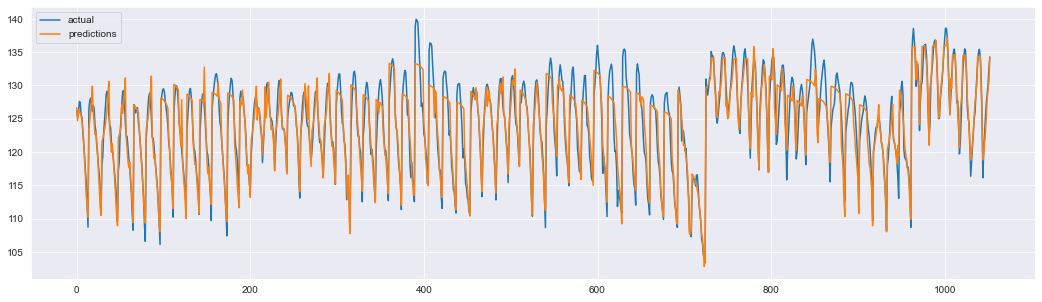

In [34]:
create_plot(train_df, tree)

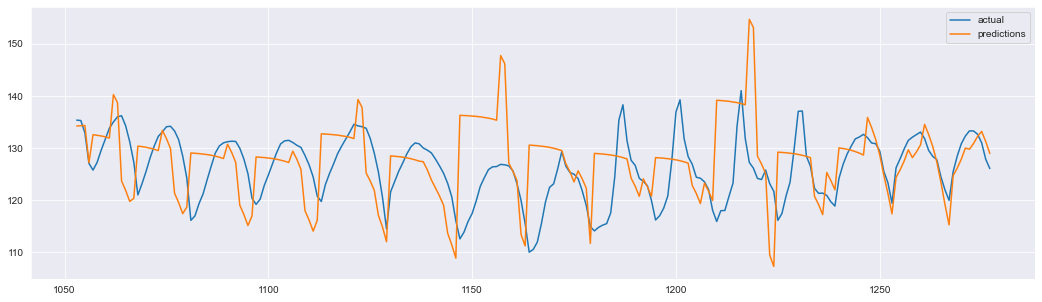

In [35]:
create_plot(val_df, tree)

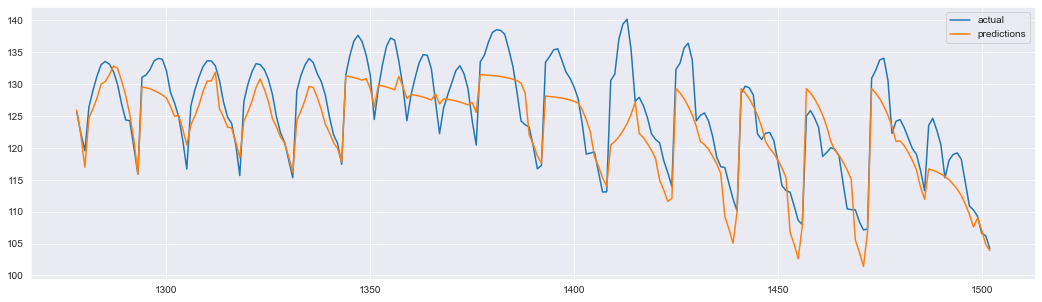

In [36]:
create_plot(test_df, tree)

# QSAR aquatic toxicity Data Set

## Load and Prepare the Data

In [37]:
df = pd.read_csv("qsar_aquatic_toxicity.csv", sep=";", header=None)
df.size

4914

In [38]:
for i in range(8):
    column = 'column_'+str(i)
    df[column] = df[i]
    df = df.drop(i, axis=1)
df["label"] = df[8]
df = df.drop(8, axis=1)

In [39]:
df.head()

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,label
0,0.00,0.0,0,2.419,1.225,0.667,0,0,3.740
1,0.00,0.0,0,2.638,1.401,0.632,0,0,4.330
2,9.23,11.0,0,5.799,2.930,0.486,0,0,7.019
3,9.23,11.0,0,5.453,2.887,0.495,0,0,6.723
4,9.23,11.0,0,4.068,2.758,0.695,0,0,5.979


In [40]:
df.isnull().sum()

column_0    0
column_1    0
column_2    0
column_3    0
column_4    0
column_5    0
column_6    0
column_7    0
label       0
dtype: int64

## Train-Val-Test Split

In [41]:
train_df, val_df, test_df = train_val_test_split(df, 0.15, 0.15)

## Grid Search

In [42]:
grid_search = {"max_depth": [], "min_samples": [], "r_squared_train": [], "r_squared_val": [], "r_squared_test": []}
for max_depth in range(1, 7): 
    for min_samples in range(1, 25, 4):
        tree = decision_tree_algorithm(train_df, max_depth=max_depth, min_samples=min_samples)
        
        r_squared_train = calculate_r_squared(train_df, tree)
        r_squared_val = calculate_r_squared(val_df, tree)
        r_squared_test = calculate_r_squared(test_df, tree)
        
        grid_search["max_depth"].append(max_depth)
        grid_search["min_samples"].append(min_samples)
        grid_search["r_squared_train"].append(r_squared_train)
        grid_search["r_squared_val"].append(r_squared_val)
        grid_search["r_squared_test"].append(r_squared_test)
        
    print(f"Progress: Iteration {max_depth}/6")
        
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("r_squared_val", ascending=False).head()
grid_search.sort_values("r_squared_test", ascending=False).head()

Progress: Iteration 1/6
Progress: Iteration 2/6
Progress: Iteration 3/6
Progress: Iteration 4/6
Progress: Iteration 5/6
Progress: Iteration 6/6


,max_depth,min_samples,r_squared_train,r_squared_val,r_squared_test
0,1,1,0.987652,0.981312,0.971464
1,1,5,0.987652,0.981312,0.971464
2,1,9,0.987652,0.981312,0.971464
3,1,13,0.987652,0.981312,0.971464
4,1,17,0.987652,0.981312,0.971464


## Plotting a Tree

In [43]:
best_max_depth = 1
best_min_samples = 5

tree = decision_tree_algorithm(train_df, max_depth=best_max_depth, min_samples=best_min_samples)
pprint(tree)

{'column_3 <= 1.947': [(array([ 0.03471958, -0.01161215, -0.16691536,  0.24993094,  0.17966562,
       -1.13763328, -0.30064086, -0.19353211]),
                        3.992055112623698),
                       (array([ 0.02606247, -0.01523761, -0.11614531,  0.37204536,  0.66107018,
       -0.73301889, -0.1159507 , -0.05039344]),
                        2.9019617140502234)]}


## Estimating Accuracy using $R^2$

In [44]:
calculate_r_squared(test_df, tree)

0.9714644763614496

## Visualizing Actual and Predicted Data

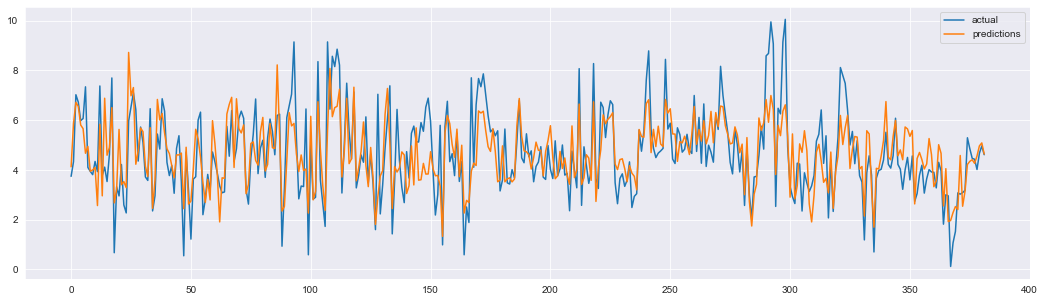

In [45]:
create_plot(train_df, tree)

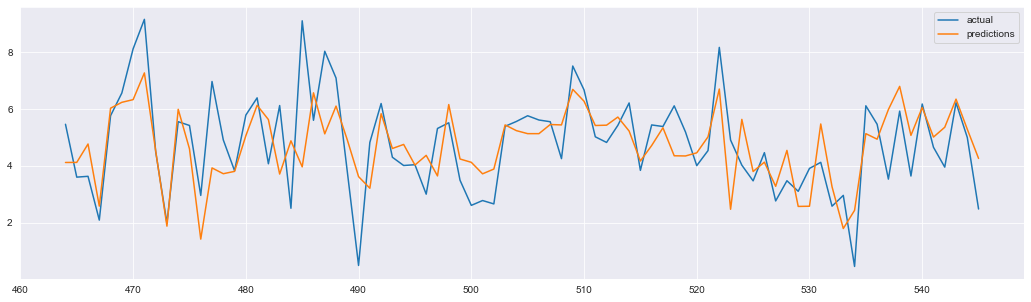

In [46]:
create_plot(test_df, tree)

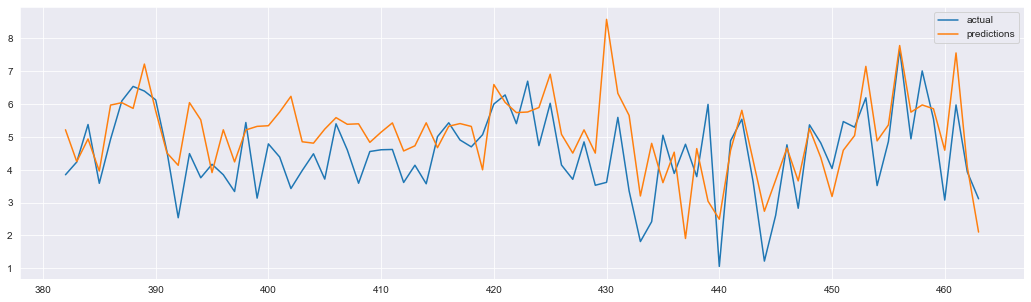

In [47]:
create_plot(val_df, tree)

# QSAR fish toxicity Data Set

## Load and Prepare the Data

In [48]:
df = pd.read_csv("qsar_fish_toxicity.csv", sep=";", header=None)
df.size

6356

In [49]:
for i in range(6):
    column = 'column_'+str(i)
    df[column] = df[i]
    df = df.drop(i, axis=1)
df["label"] = df[6]
df = df.drop(6, axis=1)

In [50]:
df.head()

,column_0,column_1,column_2,column_3,column_4,column_5,label
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390


In [51]:
df.isnull().sum()

column_0    0
column_1    0
column_2    0
column_3    0
column_4    0
column_5    0
label       0
dtype: int64

## Train-Val-Test Split

In [52]:
train_df, val_df, test_df = train_val_test_split(df, 0.15, 0.15)

## Grid Search

In [53]:
grid_search = {"max_depth": [], "min_samples": [], "r_squared_train": [], "r_squared_val": [], "r_squared_test": []}
for max_depth in range(1, 7): 
    for min_samples in range(1, 25, 4):
        tree = decision_tree_algorithm(train_df, max_depth=max_depth, min_samples=min_samples)
        
        r_squared_train = calculate_r_squared(train_df, tree)
        r_squared_val = calculate_r_squared(val_df, tree)
        r_squared_test = calculate_r_squared(test_df, tree)
        
        grid_search["max_depth"].append(max_depth)
        grid_search["min_samples"].append(min_samples)
        grid_search["r_squared_train"].append(r_squared_train)
        grid_search["r_squared_val"].append(r_squared_val)
        grid_search["r_squared_test"].append(r_squared_test)
        
    print(f"Progress: Iteration {max_depth}/6")
        
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("r_squared_val", ascending=False).head()
grid_search.sort_values("r_squared_test", ascending=False).head()

Progress: Iteration 1/6
Progress: Iteration 2/6
Progress: Iteration 3/6
Progress: Iteration 4/6
Progress: Iteration 5/6
Progress: Iteration 6/6


,max_depth,min_samples,r_squared_train,r_squared_val,r_squared_test
0,1,1,0.912826,0.902568,0.934371
2,1,9,0.912826,0.902568,0.934371
3,1,13,0.912826,0.902568,0.934371
4,1,17,0.912826,0.902568,0.934371
5,1,21,0.912826,0.902568,0.934371


## Plotting a Tree

In [54]:
best_max_depth = 1
best_min_samples = 1

tree = decision_tree_algorithm(train_df, max_depth=best_max_depth, min_samples=best_min_samples)
pprint(tree)

{'column_5 <= 1.717': [(array([ 0.07313489,  1.68790816, -0.9063243 ,  0.8307433 ,  0.06989434,
        0.20421059]),
                        3.0330252255734718),
                       (array([ 0.30555653,  1.07548584, -0.41760637,  0.26533113,  0.08808327,
        0.39689118]),
                        2.212057929783308)]}


## Estimating Accuracy using $R^2$

In [55]:
calculate_r_squared(test_df, tree)

0.9343710482417276

## Visualizing Actual and Predicted Data

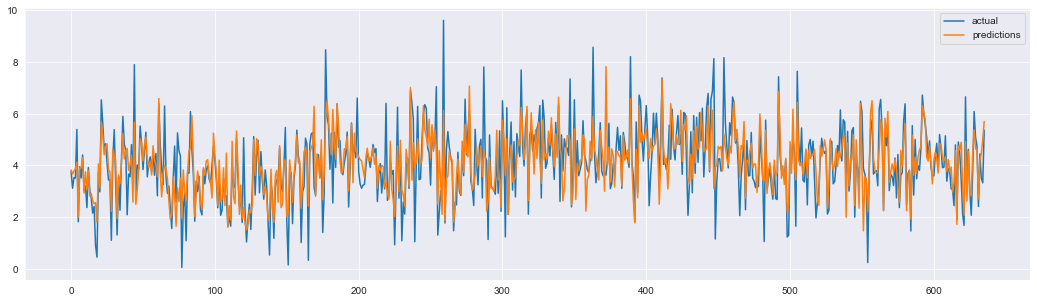

In [56]:
create_plot(train_df, tree)

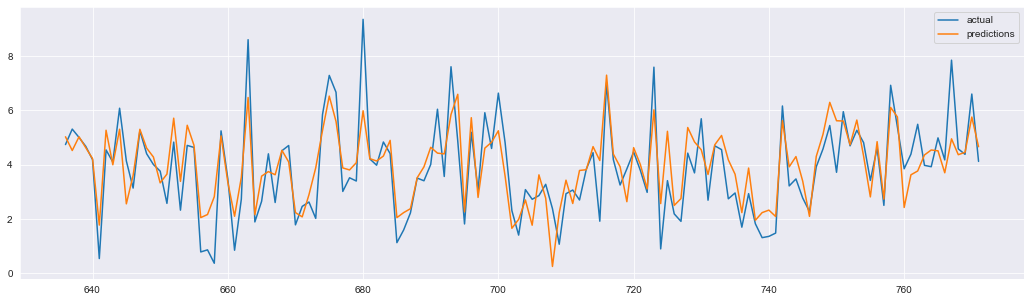

In [57]:
create_plot(val_df, tree)

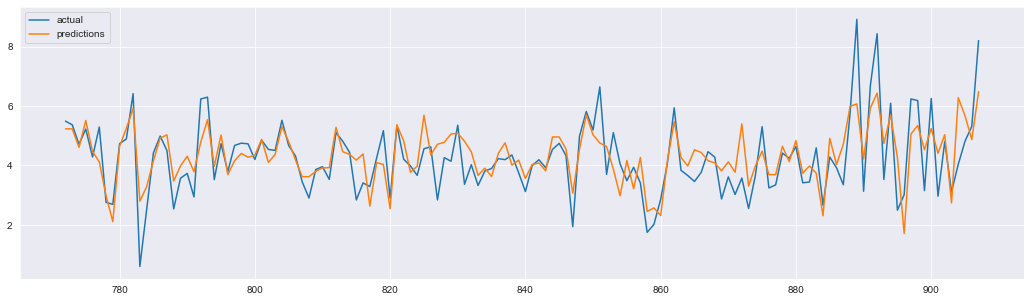

In [58]:
create_plot(test_df, tree)